In [29]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime, timedelta
import os

In [4]:
file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/troll/radar/'

file_list = sorted(glob.glob('/gws/nopw/j04/tone_ico_gws/cloudnet/troll/radar/2025*.nc'))  # Adjust path based on month


In [22]:
ds = nc.Dataset(file_list[1])

In [7]:
print(ds)

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.8
    cloudnetpy_version: 1.70.1
    file_uuid: 07b14537-223d-4d02-90be-88d618250ed2
    cloudnet_file_type: radar
    title: RPG-FMCW-35 cloud radar from Troll Station
    year: 2025
    month: 03
    day: 01
    location: Troll Station
    history: 2025-03-02 00:35:51 +00:00 - radar file created
    source: RPG-Radiometer Physics RPG-FMCW-35
    references: https://doi.org/10.21105/joss.02123
    pid: https://hdl.handle.net/21.12132/1.07b14537223d4d02
    cloudnet_processing_version: 2.51.2
    instrument_pid: https://hdl.handle.net/21.12132/3.82bd078f71da4bba
    dimensions(sizes): time(14123), range(710), chirp_sequence(3)
    variables(dimensions): int32 file_code(), int32 program_number(), int32 model_number(), float32 radar_frequency(), float32 antenna_separation(), float32 antenna_diameter(), float32 antenna_gain(), float32 half_power_beam_width(), int32 dual_polarization(

In [23]:
#print(ds.variables['Zh'])
print(ds.variables['time'])
print(ds.variables['time'][1]-ds.variables['time'][0])
print(ds.variables['time'][-3]-ds.variables['time'][-2])

<class 'netCDF4.Variable'>
float32 time(time)
    units: hours since 2025-03-02 00:00:00 +00:00
    long_name: Time UTC
    standard_name: time
    axis: T
    calendar: standard
unlimited dimensions: 
current shape = (13536,)
filling off
0.00081944466
-0.00082206726


In [99]:
radar_accum = np.zeros([31])
daily_accum = {}

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm
    daily_accum[base_time.date()] = accumulation

    radar_accum[i] = accumulation
    i = i + 1


daily_series = pd.Series(daily_accum)
daily_series.index = pd.to_datetime(daily_series.index)
daily_series.name = 'snowfall_accumulation_mm'
daily_series.index.name = 'date'
daily_series.to_csv('troll_radar_march_accum.csv')


/tmp/ipykernel_329250/626099281.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [ ]:
radar_accum = np.zeros([31])
daily_accum = {}

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm
    daily_accum[base_time.date()] = accumulation

    radar_accum[i] = accumulation
    i = i + 1


daily_series = pd.Series(daily_accum)
daily_series.index = pd.to_datetime(daily_series.index)
daily_series.name = 'snowfall_accumulation_mm'
daily_series.index.name = 'date'
daily_series.to_csv('troll_radar_march_accum.csv')


7.27415847305925


In [50]:
#file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/20230426_neumayer_mira.nc'
modfile_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/troll/era5/8c77d7d4c6e1d8b637bca6cfa6a85450.nc'
model = nc.Dataset(modfile_path)

# Coords of Neumayer III
minMod = np.array(model.variables['mntpr'][:, 48, 730]) * 60 * 60
maxMod = np.array(model.variables['mxtpr'][:, 48, 730]) * 60 * 60

print(model)

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2025-06-12T11:59 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.41.0 with {"source": "tmp9dk4r87w/data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["max"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(2364), latitude(121), longitude(1440)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 mxtpr(valid_time, latitude, longitude), float32 mntpr(valid_time, latitude, longitude)
    groups: 


In [54]:
print(model.variables['latitude'][48])
print(model.variables['longitude'][730])
print(model.variables['valid_time'])

-72.0
2.5
<class 'netCDF4.Variable'>
int64 valid_time(valid_time)
    long_name: time
    standard_name: time
    units: seconds since 1970-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (2364,)
filling on, default _FillValue of -9223372036854775806 used


In [ ]:
print(model.variables['valid_time'][0])
#1743465600

1743465600


In [67]:
eraUpperAccum = np.trapz(maxMod[:744])
eraLowerAccum = np.trapz(minMod[:744])

print(eraUpperAccum)
print(eraLowerAccum)

12.239885
10.021591


/tmp/ipykernel_329250/1341137282.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraUpperAccum = np.trapz(maxMod[:744])
/tmp/ipykernel_329250/1341137282.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraLowerAccum = np.trapz(minMod[:744])


In [71]:
accum_daily_low = np.sum(minMod[:744].reshape(31, 24), axis=1)
accum_daily_high = np.sum(maxMod[:744].reshape(31, 24), axis=1)


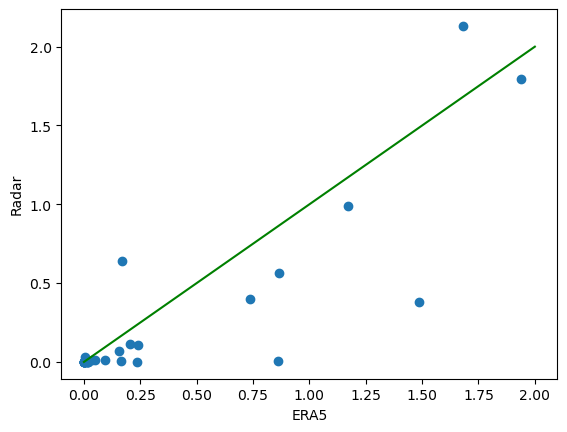

In [78]:
plt.scatter(accum_daily_low, radar_accum)
plt.xlabel("ERA5")
plt.ylabel("Radar")
plt.plot(np.arange(0, 3), np.arange(0, 3), c='g')

In [79]:
radar_accum_upper = np.zeros([31])

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 43
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm

    radar_accum_upper[i] = accumulation
    i = i + 1





/tmp/ipykernel_329250/3114587061.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [81]:
radar_accum_lower = np.zeros([31])

i = 0
for file in file_list:
    dset = nc.Dataset(file)

    dbz = np.array(dset.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 11
    b = 1.1

    precip = (z / a) ** (1 / b)

    basename = os.path.basename(file)
    date_str = basename.split('_')[0]
    base_time = datetime.strptime(date_str, '%Y%m%d')

    

    # Extract time (hours since midnight)
    time_var = dset.variables['time'][:]
    
    # Convert time to seconds
    time_sec = time_var * 3600  # NumPy array

    # Remove NaNs
    valid_mask = ~np.isnan(precip)
    precip_clean = precip[valid_mask]
    time_sec_clean = time_sec[valid_mask]

    accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm

    radar_accum_lower[i] = accumulation
    i = i + 1





/tmp/ipykernel_329250/270532013.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  accumulation = np.trapz(precip_clean, time_sec_clean) / 3600  # result in mm


In [82]:
print(np.sum(radar_accum_lower))
print(np.sum(radar_accum_upper))


11.382010101545738
3.295856127532444


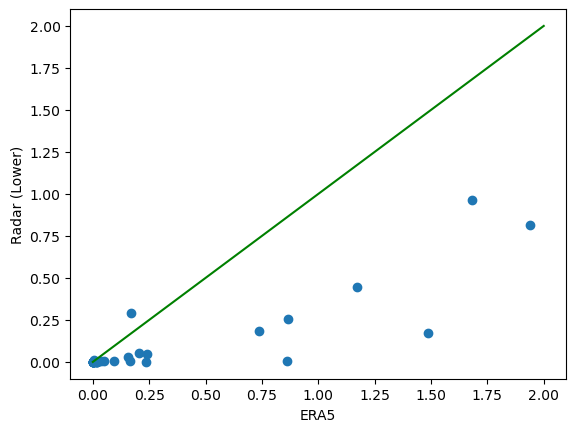

In [84]:
plt.scatter(accum_daily_low, radar_accum_upper)
plt.xlabel("ERA5")
plt.ylabel("Radar (Lower)")
plt.plot(np.arange(0, 3), np.arange(0, 3), c='g')

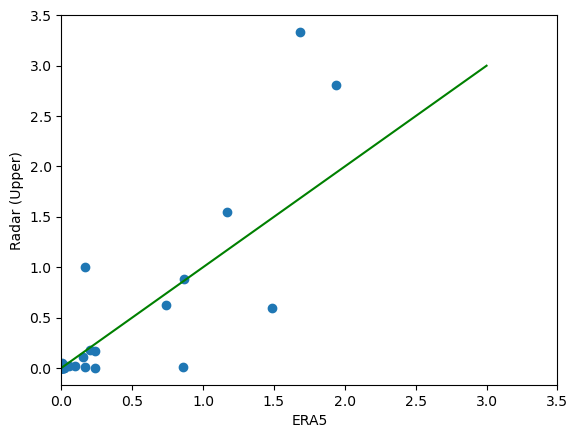

In [87]:
plt.scatter(accum_daily_low, radar_accum_lower)
plt.xlabel("ERA5")
plt.ylabel("Radar (Upper)")
plt.xlim(0, 3.5)
plt.plot(np.arange(0, 4), np.arange(0, 4), c='g')

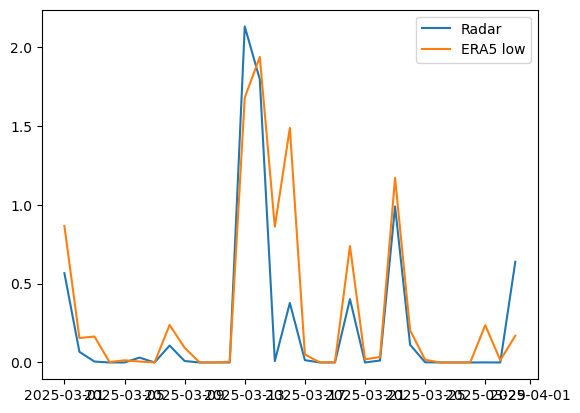

In [103]:
dates = np.arange('2025-03-01', '2025-04-01', dtype='datetime64[D]')

plt.plot(dates, radar_accum, label='Radar')
plt.plot(dates, accum_daily_low, label='ERA5 low')
#plt.plot(dates, accum_daily_high, label='ERA5 high')
plt.legend()

In [107]:
print("Radar accumulation = " + str(np.sum(radar_accum)) + " mm")
print("ERA5 lower accumulation = " + str(np.sum(accum_daily_low)) + " mm")
print("ERA5 upper accumulation = " + str(np.sum(accum_daily_high)) + " mm")

Radar accumulation = 7.27415847305925 mm
ERA5 lower accumulation = 10.170937 mm
ERA5 upper accumulation = 12.414551 mm
